### Regridding data to climate grid scale
[18-09-19]

In [157]:
# Libraries
%load_ext autoreload
%autoreload

import numpy as np
import iris
import iris.coord_categorisation
import pandas as pd

import sys
sys.path.append('../')
from libs.plot_maps import *


import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
# Loading in the data
dir = '../data/'
files = {'cropland'     :'states.TRENDYv8.proc.crop.n96e.nc',
         'fract_agr'    :'states.TRENDYv8.proc.frac_agr.n96e.nc',
         'pasture'      :'states.TRENDYv8.proc.pastr.n96e.nc'}


input_data = {}

for key, f in files.items():
    dat = iris.load_cube(dir + f, 'area_fraction')
    input_data[key] = dat

Need to add in the dimension coordinates for latitude and longitude, so we're going to load in a UKESM file to pinch the lat and lon dim coords from there

In [159]:
template = iris.load_cube(dir + 'qrparm.veg.frac.nc')

# Taking the array of the coordinates
lat = template.coord('latitude').points
lon = template.coord('longitude').points

Setting up the coordinates

In [160]:
# Dim coord for latitude (index: 1)
coord_lat = iris.coords.DimCoord(lat, standard_name='latitude',
                                 coord_system=iris.coord_systems.GeogCS(6371229.0),var_name='latitude',
                                 units='degrees')

# Dim coord for longitude (index: 2)
coord_lon = iris.coords.DimCoord(lon, standard_name='longitude',
                                 coord_system=iris.coord_systems.GeogCS(6371229.0),var_name='longitude',
                                 units='degrees')

Loading in the mask to use for regridding

In [161]:
dir_mask = '../data/climate/'
file = 'climate_mask.nc'

mask = iris.load_cube(dir_mask + file)

### Regridding the data

In [162]:
regrid_data = {}
for key in input_data.keys():
    
    # Adding dimension coordinates to data
    try:        
        mask.coord('latitude').guess_bounds()
        mask.coord('longitude').guess_bounds()
    except:
        pass
    
    try:
        input_data[key].add_dim_coord(coord_lat, 1)
        input_data[key].add_dim_coord(coord_lon, 2)
    except:
        pass
    try:
        input_data[key].coord('longitude').guess_bounds()
        input_data[key].coord('latitude').guess_bounds()
    except:
        pass
    # Regridding the data
    regrid_data[key] = input_data[key].regrid(mask, iris.analysis.AreaWeighted())

Compare to original files

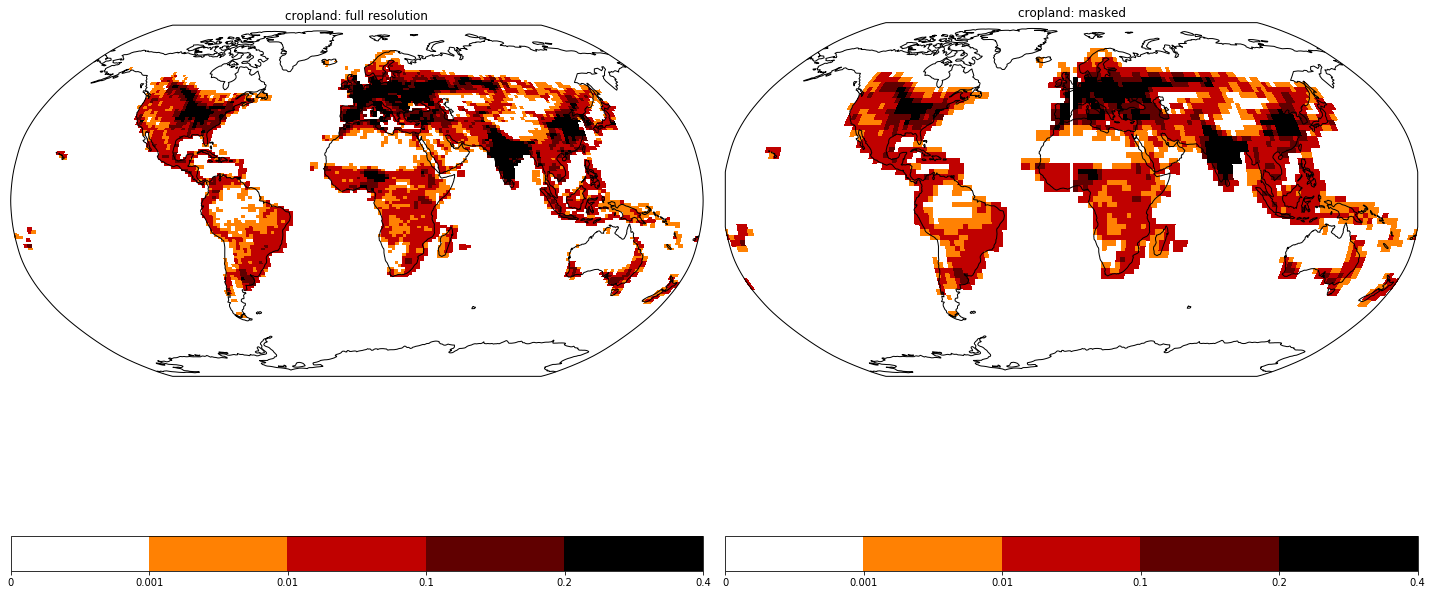

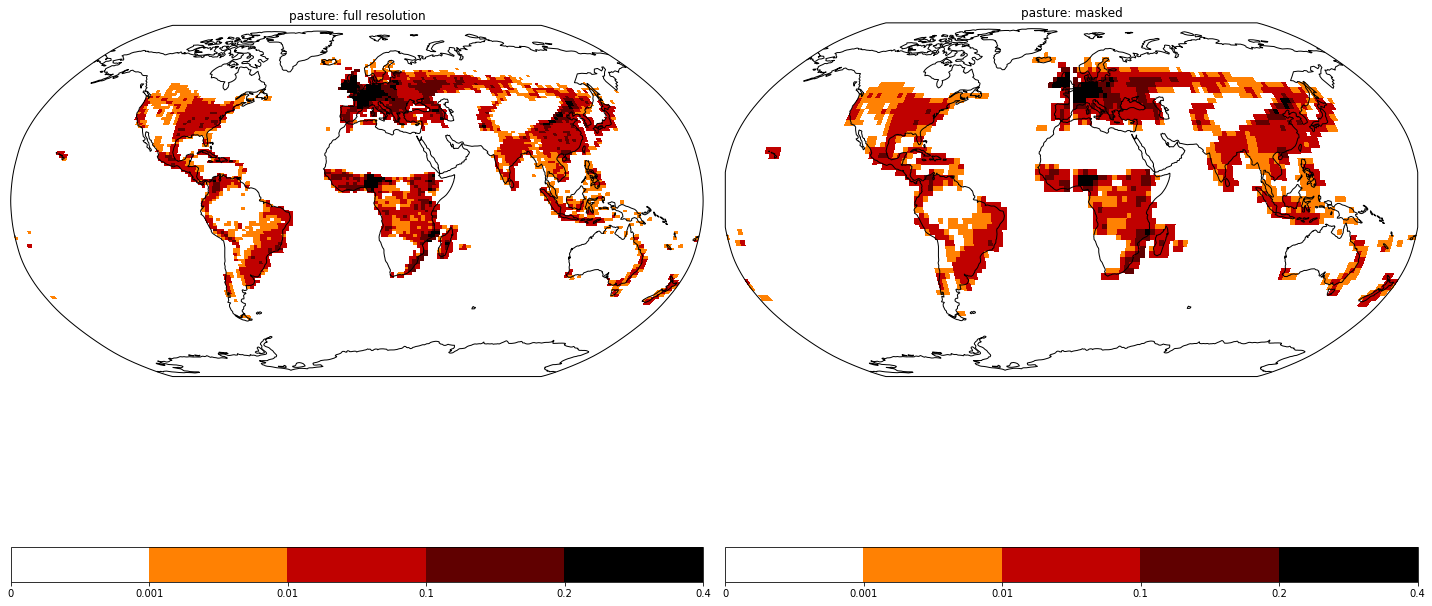

In [163]:
plt.rcParams['figure.figsize'] = [20, 45]

i = 1

for key in regrid_data.keys():
    if key is not "fract_agr":
    #    plt.subplot(1, 2, 1)
        dat1 = input_data[key].collapsed('time', iris.analysis.MEAN)
        plot_lonely_cube(dat1, len(regrid_data.keys()), 2, i, cmap = 'gist_heat_r', levels = [0, 0.001, 0.01, 0.1, 0.2, 0.4])
        plt.title('%s: full resolution' %key)
        i = i + 1

    #    plt.subplot(1, 2, 2)
        dat2 = regrid_data[key].collapsed('time', iris.analysis.MEAN)
        plot_lonely_cube(dat2, len(regrid_data.keys()), 2, i, cmap = 'gist_heat_r', levels = [0, 0.001, 0.01, 0.1, 0.2, 0.4])
        plt.title('%s: masked' %key)
        plt.show()
        i = i + 1

### Interpolate post 2000 to monthly

Template from climate data

In [179]:
dir_temp = '../outputs/climate/'
file_temp = 'air2001-2019.nc'
temp = iris.load_cube(dir_temp + file_temp)

In [184]:

post_2001 = {}
j = 0
for key in regrid_data.keys():
    dat = temp.copy()
    print(key)
    # We need to put data directly into post_2001.data so we have to give it a frame first
    post_2001[key] = temp.copy()
    j = 0
    for year in range(19):
        if year <= 17:
            for m in range(12):
                dat.data[j] = regrid_data[key].data[year+302]*(m/12) + regrid_data[key].data[year+301]*((12-m)/12)
                j += 1
                print('year: ', year+2001, 'and j: ', j, 'and m: ', m)
        else:
            for n in range(8):
                dat.data[j] = regrid_data[key].data[-1]
                j += 1
                print('year: ', year+2001, 'and j: ', j)
    post_2001[key].data = dat.data

cropland
year:  2001 and j:  1 and m:  0
year:  2001 and j:  2 and m:  1
year:  2001 and j:  3 and m:  2
year:  2001 and j:  4 and m:  3
year:  2001 and j:  5 and m:  4
year:  2001 and j:  6 and m:  5
year:  2001 and j:  7 and m:  6
year:  2001 and j:  8 and m:  7
year:  2001 and j:  9 and m:  8
year:  2001 and j:  10 and m:  9
year:  2001 and j:  11 and m:  10
year:  2001 and j:  12 and m:  11
year:  2002 and j:  13 and m:  0
year:  2002 and j:  14 and m:  1
year:  2002 and j:  15 and m:  2
year:  2002 and j:  16 and m:  3
year:  2002 and j:  17 and m:  4
year:  2002 and j:  18 and m:  5
year:  2002 and j:  19 and m:  6
year:  2002 and j:  20 and m:  7
year:  2002 and j:  21 and m:  8
year:  2002 and j:  22 and m:  9
year:  2002 and j:  23 and m:  10
year:  2002 and j:  24 and m:  11
year:  2003 and j:  25 and m:  0
year:  2003 and j:  26 and m:  1
year:  2003 and j:  27 and m:  2
year:  2003 and j:  28 and m:  3
year:  2003 and j:  29 and m:  4
year:  2003 and j:  30 and m:  5
year: 

year:  2010 and j:  120 and m:  11
year:  2011 and j:  121 and m:  0
year:  2011 and j:  122 and m:  1
year:  2011 and j:  123 and m:  2
year:  2011 and j:  124 and m:  3
year:  2011 and j:  125 and m:  4
year:  2011 and j:  126 and m:  5
year:  2011 and j:  127 and m:  6
year:  2011 and j:  128 and m:  7
year:  2011 and j:  129 and m:  8
year:  2011 and j:  130 and m:  9
year:  2011 and j:  131 and m:  10
year:  2011 and j:  132 and m:  11
year:  2012 and j:  133 and m:  0
year:  2012 and j:  134 and m:  1
year:  2012 and j:  135 and m:  2
year:  2012 and j:  136 and m:  3
year:  2012 and j:  137 and m:  4
year:  2012 and j:  138 and m:  5
year:  2012 and j:  139 and m:  6
year:  2012 and j:  140 and m:  7
year:  2012 and j:  141 and m:  8
year:  2012 and j:  142 and m:  9
year:  2012 and j:  143 and m:  10
year:  2012 and j:  144 and m:  11
year:  2013 and j:  145 and m:  0
year:  2013 and j:  146 and m:  1
year:  2013 and j:  147 and m:  2
year:  2013 and j:  148 and m:  3
year:  20

### Save the outputs

In [185]:
for key, dat in post_2001.items():
    new_file_names = key + "2001-2019.nc"
    out = '../outputs/human/' + new_file_names
    print(new_file_names)
    iris.save(dat, out)

cropland2001-2019.nc
fract_agr2001-2019.nc
pasture2001-2019.nc


In [182]:
post_2001[key]

<iris 'Cube' of Monthly Mean Air Temperature at sigma level 0.995 / (degC) (time: 224; latitude: 73; longitude: 144)>

In [111]:
post_2001 = input_data
for key in input_data.keys():
    # Add coord of year
    try:
        iris.coord_categorisation.add_year(input_data[key], 'time', name='year')
    except:
        pass

    # Extract from 2001 onwards
    post_2001[key] = input_data[key].extract(iris.Constraint(year=lambda y: y >= 2001))

## Post 2001

Putting the land use data into a climate cube and setting it to 2001-2019 and interpolating it.

In [50]:
dir = '../data/land_use/'
files = {'cropland'     :'cropland_masked.nc',
         'fract_agr'    :'fract_agr_masked.nc',
         'pasture'      :'pasture_masked.nc'}


input_data = {}

for key, f in files.items():
    dat = iris.load_cube(dir + f)
    input_data[key] = dat

OSError: One or more of the files specified did not exist:
    * "/prj/ukesm/doukel/amazon_fires/outputs/human/cropland_masked.nc" didn't match any files

In [11]:
# Saving the last 19 time points (given in yearly data)
# post_2001 = {}
# for key in input_data.keys():
#     post_2001[key].data = input_data[key][-20]

#### Saving outputs

In [33]:
for key in input_data.keys():
    out = key + '2001-2019.nc'
    iris.save(post_2001[key], dir + out)